In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline


In [2]:
from os.path import expanduser
home = expanduser('~')
gc_dir = home + "/Dropbox/GalacticCenter/"

In [23]:
E = 5 

In [24]:
# extract the lightcurve data points

#lc_data = numpy.genfromtxt(gc_dir+"/log/lightCurves/SgrA_lightCurve_both_4tels_all_E"+str(E)+"_annual_points.txt")
lc_data = numpy.genfromtxt(gc_dir+"/log/lightCurves/SgrA_lightCurve_both_E"+str(E)+"_annual_points.txt")

MJD_array = numpy.array(lc_data[:,0], dtype=numpy.float64)
flux_obs_array = numpy.array(lc_data[:,1], dtype=numpy.float64)
flux_err_array = numpy.array(lc_data[:,2], dtype=numpy.float64)
livetime_array = numpy.array(lc_data[:,3], dtype=numpy.float64)

print(flux_obs_array)
#log = list(map(lambda l: numpy.log10(l), _array))


[  2.78149000e-09   2.81523000e-09   3.14180000e-09   2.13560000e-09
   2.16522000e-09   2.08852000e-09]


In [25]:

total_livetime = numpy.sum(livetime_array)
fluxtime_array = flux_obs_array * livetime_array
mean_flux = numpy.sum(fluxtime_array) / total_livetime
print(mean_flux)
flux_obs_array[ flux_obs_array==0 ] = numpy.nan
flux_err_array[ flux_err_array==0 ] = numpy.nan
fluxtime_array[ fluxtime_array==0 ] = numpy.nan


2.50514371418e-09


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


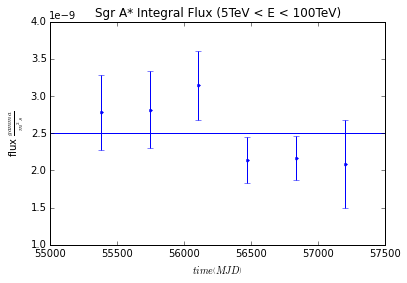

In [26]:
pyplot.errorbar(MJD_array, flux_obs_array, yerr=flux_err_array, fmt='b.') # 

pyplot.title("Sgr A* Integral Flux ("+str(E)+"TeV < E < 100TeV)")
pyplot.xlabel(r"$time\left(MJD\right)$")
pyplot.ylabel(r"flux $\frac{gamma}{m^{2}s}$") # gamma / m^2*s*TeV
#pyplot.xlim(1.5e0, 5.e1)
#pyplot.ylim(0., 2e-9)
pyplot.axhline(mean_flux)

#pyplot.savefig(gc_dir+"/plots/lightCurve/SgrA_lightcurve_all_4tels_seasonal.png")
pyplot.savefig(gc_dir+"/plots/lightCurve/SgrA_lightcurve_all_4tels_E"+str(E)+"_seasonal.png")
